# Overview

This notebook prepares landings records from the Government of Greenland, Fisheries Department, Fisheries License Control Authority, for the purposes of reproducing the results of the sea ice fishing study.


## Load Packages


This portion of the notebook loads in all of the packages required to run the subsequent code cells.


In [95]:
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.covariance import EllipticEnvelope
from tqdm.notebook import tqdm
import json
from pathlib import Path
import statsmodels.formula.api as smf


## Load and Clean Landings Records


The landings records that are used in the study are originally recorded by hand in the various landing sites, most commonly fish factories. These records are subject to input error, and formatting error. The following actions identify and resolve errors that prevent accurate interpretation of fishing activities.


In [96]:
landings = pd.read_csv(
    "../data/raw/landings_raw.csv",
    index_col=0,
    encoding="ISO-8859-1",
    low_memory=False,
    na_values=["I/O"],
)

### Create New Variable for the Vessel Type

To evaluate changes in fishing activity on both the water and the ice, we classify the current vessel types into either water or ice vessels. We also change the vessel type variable, which normally contains the individual vessel types, to be either a water or ice vessel. We create a new variable called vessel, which contains the specific type of vessel.


In [97]:
vessels = {
    "UJOLLE": None,
    "USLAEDE": None,
    "Dinghy": "water",
    "Larger Inshore Vessel": "water",
    "Sled": "ice",
    "Snowmobile": "ice",
    "ATV": None,
}
landings["vessel"] = landings.vessel_type
landings["vessel_type"] = landings.vessel.map(vessels)

### Correct Erroneous Localities Values

Some of the localities include districts, which complicate interpretation of results. We group some districts into their parent locality.


In [98]:
wrong_localities = {
    "Aappilattoq Nanortalimmi": "Nanortalik",
    "Aappilattoq Upernavimmi": "Upernavik",
    "Kuummiit": "Kuummiut",
    "Nuussuaq, Nuuk": "Nuuk",
    "Nuussuaq, Upernavik": "Upernavik",
    "Tasiusaq Nanortalimmi": "Nanortalik",
    "Tasiusaq, Nanortalimmi": "Nanortalik",
    "Tasiusaq, Upernavik": "Upernavik",
    "Tiileqilaaq": "Tiniteqilaaq",
}

landings.sellers_locality = landings.sellers_locality.replace(
    to_replace=wrong_localities
)
landings.buyers_locality = landings.buyers_locality.replace(to_replace=wrong_localities)

### Correct Gears

Some of the gears described are classified separarely from each other but are the same. We group these together. We also ensure that the number of tools (aka gears) used is greater than 0.


In [99]:
wrong_gears = {
    "Set gillnets": "Gill nets",
    "Gill nets": "Gill nets",
    "Longlines (not specified)": "Longlines",
}

landings["gears"] = landings.gear_en.replace(to_replace=wrong_gears)
landings = landings[landings["num_tools"] > 0]

### Drop Erroneous Records

Landing records without the landing date, the seller id, the position of the harvest, or the locality of the seller, are not able to be evaluated. We drop these records. We also drop records where the fishing time indicated is less than zero. Fishing time is used to calculate efficiency of fishing, in the form of catch per unit of effort. When fishing time is missing, catch per unit of effort cannot be calculated.


In [100]:
# Some missing data are okay, but some are an immediate disqualifier for further analysis of that row
landings = landings.dropna(
    subset=["landing_date", "seller_id", "field_code", "sellers_locality"]
)
landings = landings[landings["fishing_time"] > 0]

### Clean Up Field Codes

Field codes are used to grid cell Greenland's fishing areas. These data come from Greenland Fisheries License Control Authority. The spatial information for each landing in the landing records are dropped and the spatial information for each field code is merged onto the landing records. These information are more accurate and less error-prone.


In [101]:
field_codes = pd.read_csv("../resources/fieldcodes.csv")

In [102]:
landings["field_code"] = landings.field_code.str.replace("-", "")


def insert_zero_padding(field_code):
    try:
        return field_code[:2] + f"{int(field_code[2:]):03d}"
    except (ValueError, TypeError):
        return field_code


landings["field_code"] = landings.field_code.apply(insert_zero_padding)

In [103]:
landings = landings.drop(columns=["latitude", "longitude"])

In [104]:
landings = landings.merge(right=field_codes)

## Load Locality Information

Information about the localities is limited in the landing records. We bring in additional information, including the type of locality and the municipality it is a part of.


In [105]:
locality_info = pd.read_csv("../resources/localities.csv")
locality_info = locality_info[["locality", "municipality", "settlement_size"]]
locality_info = locality_info.dropna()
locality_info

,locality,municipality,settlement_size
0,Nerlerit Inaat,Sermersooq,Bygd
2,Sirius,UFK,Station
3,Akunnaaq,Qaasuitsup,Bygd
4,Kitsissuarsuit,Qaasuitsup,Bygd
5,Ikkatteq,Sermersooq,Bygd
...,...,...,...
91,Daneborg,UFK,Station
93,Ikamiut,Qaasuitsup,Bygd
94,Nutaarmiut,Qaasuitsup,Bygd
95,"Ikerasaarsuk, Upernavik",Qaasuitsup,Bygd


In [106]:
landings = landings.merge(
    locality_info, left_on="sellers_locality", right_on="locality"
).drop(columns="locality")

## Create Derived Variables


### Create Seasonal Year

To evaluate fishing from Jan-Dec of each year is not helpful because ice fishing seasons occur at the end and the beginning of the year. We know that no ice fishing occurs in August, 8, so we create a seasonal year that spans from August to August of each year.


In [107]:
season_start_month = 8

landings["landing_date"] = pd.to_datetime(landings.landing_date)
landings["seasonal_year"] = landings.landing_date.apply(
    lambda x: x.year - 1 if x.month < season_start_month else x.year
)
landings = landings.query("seasonal_year >= 2012 & seasonal_year <= 2022")

### Calculate Catch Per Unit of Effort (CPUE)

Catch per unit of effort is the quotient of the landed weight of the catch and the time invested, weighted by the number of tools or gears used.


In [108]:
landings["effective_num_tools"] = landings["num_tools"]
landings.loc[landings.gears == "Longlines", "effective_num_tools"] /= 100
landings["cpue"] = (
    landings.amount_in_kg / landings.effective_num_tools / landings.fishing_time
)
landings = landings.drop(columns="effective_num_tools")

### Calculate Price Per Kilo (DKK/kg)

Kilo price paid to fishers (aka sellers) is the quotient of the sale price (dkk) and the amount of catch landed (kg).


In [109]:
landings["ppk"] = landings.value / landings.amount_in_kg
landings = landings.replace([np.inf, -np.inf], np.nan)
landings = landings.dropna(subset=["cpue", "ppk"])

### Outlier Removal

Outliers create intepretation issues and are almost always because of human input error on one of the variables, such as the amount of fish landed, the sale price, fishing time. We drop all outliers of kilo price, catch per unit of effort, and the sale price (aka value.)


In [110]:
def is_outlier(s):
    if s.shape[0] < 3:  # For less than 3 data points, outliers cannot be detected
        return s != s
    return pd.Series(
        EllipticEnvelope(support_fraction=0.8).fit_predict(s.values.reshape(-1, 1))
        == -1,
        index=s.index,
    )


landings = landings[
    ~landings.groupby("municipality", group_keys=False)["cpue"].apply(is_outlier)
]
landings = landings[
    ~landings.groupby("municipality", group_keys=False)["ppk"].apply(is_outlier)
]
landings = landings[
    ~landings.groupby("municipality", group_keys=False)["value"].apply(is_outlier)
]

### Write Out Landings Records

In [111]:
landings.to_csv("../data/derived/landings_cleaned.csv", index=None)

## Create Derived Dataframes


### Calculate Price Per Kilo According to Locality


In [137]:
landings.groupby(by=["sellers_locality", "seasonal_year", 'vessel_type']).ppk.mean().to_csv(
    "../data/derived/ppk_locality.csv"
)

### Ice Landings and Water Landings


In [113]:
ice_landings = landings.query('vessel_type == "ice"')
water_landings = landings.query('vessel_type == "water"')

### Total Daily Catch

The total daily catch refers to how much ice fishing catch was landed each day, across all of the localities, by year. This dataframe permits interpretation of the development of each fishing season in terms of catch and timing of catch.


In [114]:
total_daily_catch = (
    ice_landings.groupby(by=["seasonal_year", "landing_date"])
    .amount_in_kg.sum()
    .reset_index()
)


def calc_seasonal_days(row):
    return (
        row["landing_date"] - dt.datetime(row["seasonal_year"], season_start_month, 1)
    ).days


total_daily_catch["seasonal_day"] = total_daily_catch[
    ["landing_date", "seasonal_year"]
].apply(calc_seasonal_days, axis="columns")

total_daily_catch["cumulative"] = (
    total_daily_catch.sort_values(by="seasonal_day")
    .groupby(by=["seasonal_year"])
    .amount_in_kg.cumsum()
)

total_daily_catch.to_csv("../data/derived/total_daily_catch.csv", index=None)

### Daily Catch by Locality

Daily catch by locality refers to how much ice fishing catch was landed in each seasonal year, in each fieldcode, on each day, in each seller's locality. This dataframe permits interpretation of the distribution of catch amounts across a locality's fishing grounds.


In [115]:
locality_daily_catch = (
    ice_landings.groupby(
        by=["seasonal_year", "field_code", "landing_date", "sellers_locality"]
    )
    .amount_in_kg.sum()
    .reset_index()
)

locality_daily_catch["seasonal_day"] = locality_daily_catch[
    ["landing_date", "seasonal_year"]
].apply(calc_seasonal_days, axis="columns")

locality_daily_catch["cumulative"] = (
    locality_daily_catch.sort_values(by="seasonal_day")
    .groupby(by=["seasonal_year", "field_code", "sellers_locality"])
    .amount_in_kg.cumsum()
)


locality_daily_catch.to_csv("../data/derived/locality_daily_catch.csv", index=None)

### First Catch across all localities


In [116]:
total_first_catch = (
    total_daily_catch.groupby(by=["seasonal_year"])
    .seasonal_day.min()
    .reset_index()
    .rename(columns={"seasonal_day": "first_catch_day", "seasonal_year": "season"})
)


total_first_catch.to_csv("../data/derived/total_first_catch.csv", index=None)

### Last Catch across all localities


In [117]:
total_last_catch = (
    total_daily_catch.groupby(by=["seasonal_year"])
    .seasonal_day.max()
    .reset_index()
    .rename(columns={"seasonal_day": "last_catch_day", "seasonal_year": "season"})
)

total_last_catch.to_csv("../data/derived/total_last_catch.csv", index=None)

### First Catch at each Locality

First catch at each locality is a dataframe listing the very first ice fishing landing, no matter how big or small, in each locality, in each field code, in each seasonal year.


In [118]:
locality_first_catch = (
    locality_daily_catch.groupby(by=["seasonal_year", "field_code", "sellers_locality"])
    .seasonal_day.min()
    .reset_index()
    .rename(columns={"seasonal_day": "first_catch_day", "seasonal_year": "season"})
)

locality_first_catch.to_csv("../data/derived/locality_first_catch.csv", index=None)

### Last Catch at each Locality

Last catch at each locality is a dataframe listing the very last ice fishing landing, no matter how big or small, in each locality, in each field code, in each seasonal year.


In [119]:
locality_last_catch = (
    locality_daily_catch.groupby(by=["seasonal_year", "field_code", "sellers_locality"])
    .seasonal_day.max()
    .reset_index()
    .rename(columns={"seasonal_day": "last_catch_day", "seasonal_year": "season"})
)
locality_last_catch.to_csv("../data/derived/locality_last_catch.csv", index=None)

## Season Length (First/Last Catch Criteria)

This calculates the length of the season according to the values calculated in the code cells immediately above.


In [120]:
total_ice_season_length = (
    total_last_catch.set_index("season").last_catch_day
    - total_first_catch.set_index("season").first_catch_day
)
total_ice_season_length = total_ice_season_length.reset_index(name="ice_season_length")

# The 2022 season (going from August 2022, to August 2023) is incomplete in the dataset
total_ice_season_length = total_ice_season_length[total_ice_season_length.season < 2023]

total_ice_season_length.to_csv(
    "../data/derived/total_ice_season_length.csv", index=None
)

### First and Last Days, by Locality, 2012-2022

This dataframe brings together the first and last catch dates for each locality for each year, and which field codes were used on those dates, into one list. This list allows one to identify where the first and last fishing activity has taken place in each locality in each season.


In [121]:
first_days = (
    locality_daily_catch.groupby(by=["seasonal_year", "sellers_locality"])
    .seasonal_day.min()
    .reset_index()
    .merge(
        locality_daily_catch[
            [
                "seasonal_year",
                "sellers_locality",
                "field_code",
                "seasonal_day",
                "landing_date",
                "amount_in_kg",
            ]
        ]
    )
    .rename(columns={"seasonal_day": "catch_day", "seasonal_year": "season"})
)

first_days["first_or_last"] = "first"

last_days = (
    locality_daily_catch.groupby(by=["seasonal_year", "sellers_locality"])
    .seasonal_day.max()
    .reset_index()
    .merge(
        locality_daily_catch[
            [
                "seasonal_year",
                "sellers_locality",
                "field_code",
                "seasonal_day",
                "landing_date",
                "amount_in_kg",
            ]
        ]
    )
    .rename(columns={"seasonal_day": "catch_day", "seasonal_year": "season"})
)

last_days["first_or_last"] = "last"

locality_seasons = pd.concat([first_days, last_days]).sort_values(
    ["season", "sellers_locality"]
)

locality_seasons = locality_seasons.merge(field_codes, on="field_code")

locality_seasons = locality_seasons[
    [
        "season",
        "sellers_locality",
        "landing_date",
        "first_or_last",
        "catch_day",
        "amount_in_kg",
        "field_code",
        "latitude",
        "longitude",
    ]
].sort_values(["season", "sellers_locality"])

locality_seasons.to_csv("../data/derived/locality_seasons.csv", index=None)

### First and Last Catch Days of each field code, 2012-2022


In [122]:
field_code_first_catch_days = (
    locality_daily_catch.groupby(by=["seasonal_year", "field_code", "sellers_locality"])
    .seasonal_day.min()
    .reset_index()
    .rename(columns={"seasonal_day": "first_catch_day", "seasonal_year": "season"})
)

field_code_first_catch_days.to_csv(
    "../data/derived/field_code_first_catch_days.csv", index=None
)

field_code_last_catch_days = (
    locality_daily_catch.groupby(by=["seasonal_year", "field_code", "sellers_locality"])
    .seasonal_day.max()
    .reset_index()
    .rename(columns={"seasonal_day": "last_catch_day", "seasonal_year": "season"})
)

field_code_last_catch_days.to_csv(
    "../data/derived/field_code_last_catch_days.csv", index=None
)

### Local Ice Season Length


In [123]:
field_code_ice_season_length = (
    field_code_last_catch_days.set_index(["season", "field_code"]).last_catch_day
    - field_code_first_catch_days.set_index(["season", "field_code"]).first_catch_day
).reset_index(name="ice_season_length")

field_code_ice_season_length.to_csv(
    "../data/derived/field_code_ice_season_length.csv", index=None
)

### Number of Fields Fished, 2012-2022

This calculates the number of field codes that were fished each season.


In [124]:
num_fields = (
    field_code_first_catch_days.groupby("season")
    .field_code.nunique()
    .rename("n_fields")
)
num_fields.to_csv("../data/derived/total_num_fields.csv")

### Local Number of Fields Fished, 2012-2022

This calculates the number of field codes that were fished each season in each locality.


In [125]:
locality_num_fields = (
    ice_landings.groupby(by=["seasonal_year", "sellers_locality"])
    .field_code.nunique()
    .rename("n_fields")
)

locality_num_fields.to_csv("../data/derived/locality_num_fields.csv")

### Fishing Grounds, by Locality, by Vessel Type, by Field Code, by Seasonal Year

This identifies all of the fieldcodes that were fished in a season, from fishers in each locality, using either a water or ice vessel.


In [126]:
fishing_grounds = (
    landings.groupby(by=["seasonal_year", "sellers_locality", "vessel_type"])
    .field_code.unique()
    .explode()
    .reset_index()
)
fishing_grounds = fishing_grounds.merge(field_codes)
fishing_grounds.to_csv("../data/derived/fishing_grounds.csv", index=None)

### Locality Seasons

In [ ]:
locality_seasons = pd.read_csv("../data/derived/locality_seasons.csv")


def fit_ols(df):
    df = df.sort_values(by="season")
    if df.shape[0] < 3:
        return None
    result_first = smf.ols('catch_day~season', data=df[df.first_or_last=='first']).fit() 
    result_last = smf.ols('catch_day~season', data=df[df.first_or_last=='last']).fit() 
    return result_last.params['season'] - result_first.params['season']
    
ice_season_trend = locality_seasons.groupby("sellers_locality").apply(fit_ols).rename("ice_season_trend").reset_index()
ice_season_trend.head()

In [128]:
locality_info = pd.read_csv("../resources/locality_lat_lon.csv")
locality_info.head()

,sellers_locality,lat,lon
0,Aasiaat,68.707845,-52.852348
1,Akunnaaq,68.743124,-52.336354
2,Alluitsup Paa,60.463790,-45.567544
3,Arsuk,61.184964,-48.435389
4,Atammik,64.806106,-52.175218


In [129]:
ice_season_trend = ice_season_trend.merge(locality_info)
ice_season_trend = ice_season_trend.sort_values(by='lat', ascending=False)

In [130]:
ice_season_trend.describe()

ice_season_trend

ice_season_trend.to_csv("../data/derived/ice_season_trend.csv", index = None)


# Season Length (5% - 95% Criteria)

In [131]:
total_catch_per_year = landings.query('vessel_type == "ice"').groupby(by=['seasonal_year']).amount_in_kg.sum()

total_catch_per_year.to_csv("../data/derived/total_catch_per_year.csv", index = None)


In [132]:
#derived
lower_threshold_per_year = (total_catch_per_year * .05).to_dict()
upper_threshold_per_year = (total_catch_per_year * .95).to_dict()

def is_above_lower(row):
    return row['cumulative'] > lower_threshold_per_year[row['seasonal_year']]

def is_above_upper(row):
    return row['cumulative'] > upper_threshold_per_year[row['seasonal_year']]

total_daily_catch['season_started'] = total_daily_catch.apply(is_above_lower, axis='columns').map({False: None, True: True})
total_daily_catch['season_ended'] = total_daily_catch.apply(is_above_upper, axis='columns').map({False: None, True: True})

<AxesSubplot:xlabel='season', ylabel='day 5% reached'>

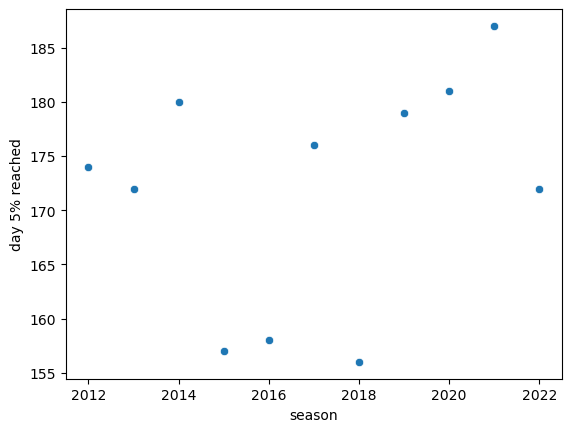

In [133]:
#derived
season_start = total_daily_catch.dropna(subset='season_started').groupby(by='seasonal_year').seasonal_day.min().reset_index().rename(columns={'seasonal_year': 'season', 'seasonal_day': 'day 5% reached'})

#viz
sns.scatterplot(data=season_start, x='season', y='day 5% reached')

<AxesSubplot:xlabel='season', ylabel='day 95% reached'>

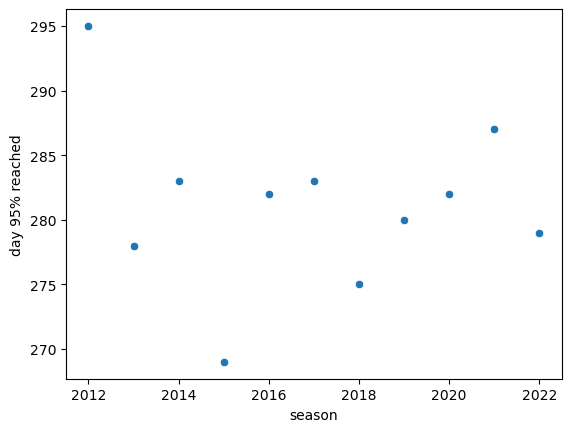

In [134]:
#derived
season_end = total_daily_catch.dropna(subset='season_ended').groupby(by='seasonal_year').seasonal_day.min().reset_index().rename(columns={'seasonal_year': 'season', 'seasonal_day': 'day 95% reached'})

#viz
sns.scatterplot(data=season_end, x='season', y='day 95% reached')

In [135]:
#derived
ice_season_length = season_end.set_index('season')['day 95% reached'] - season_start.set_index('season')['day 5% reached']
ice_season_length = ice_season_length.reset_index(name='ice_season_length')

In [136]:
#stats
ice_season_length.corr(method='kendall')

,season,ice_season_length
season,1.000000,-0.351912
ice_season_length,-0.351912,1.000000
